In [1]:
cd ..

/home/pierre/git/semisupervised


In [2]:
import numpy as np
from typing import Callable, Optional, Tuple
from module.quadrature import Quadrature, QuadratureExploration, QuadratureExplorationBis
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_GP_fit(model, distribution, train_X, targets, obj, lb=-10., up=10.):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    plt.plot(x, stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten())
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing Quadrature values

In [31]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

quad_distrib = MultivariateNormal(torch.tensor([0.]), torch.diag(torch.tensor([1.])))
train_X = torch.linspace(-3,3, 10).reshape(-1,1)
train_Y = (-(train_X)**2 + 1.).sum(dim=1, keepdim=True)
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [32]:
quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 10,
            budget = 50,
            maximize = True)

quad_distrib = MultivariateNormal(torch.tensor([0.]), torch.diag(torch.tensor([1.])))
quad.quadrature()
print("Implementation values")
print("mean quad:", quad.m)
print("variance quad:", quad.v)
print("std quad:", torch.sqrt(quad.v))

# Try with probnum
import probnum
from probnum.quad import bayesquad_from_data 
import numpy as np
domain = (0, 1)
nodes = train_X.numpy()
fun_evals = train_Y.numpy().flatten()
measure = probnum.quad.integration_measures.GaussianMeasure(0., 1.)
F, info = bayesquad_from_data(nodes=nodes, fun_evals=fun_evals, measure=measure)

print("probnum values")
print(F.mean)
print(F.var)
print(F.std)

Implementation values
mean quad: tensor(0.0005, grad_fn=<AddBackward0>)
variance quad: tensor(1.9073e-05, grad_fn=<SubBackward0>)
std quad: tensor(0.0044, grad_fn=<SqrtBackward0>)
probnum values
0.002777248261953344
5.693623762793532e-07
0.0007545610487424812


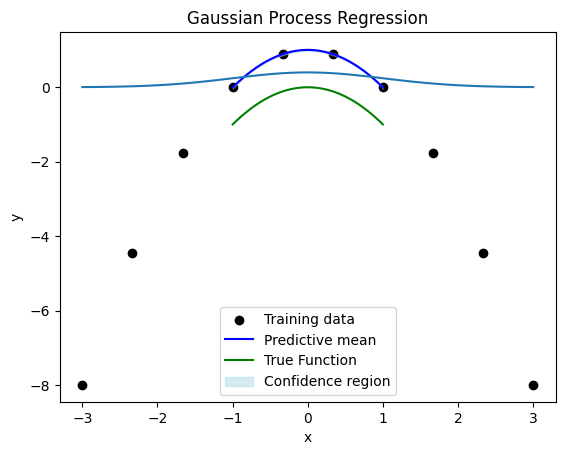

In [33]:
plot_GP_fit(model, quad_distrib, train_X, train_Y, obj = lambda x : - x**2, lb=-1., up=1.)

# Testing Acquisition Function

In [6]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

quad_distrib = MultivariateNormal(torch.tensor([0., 0.]), torch.diag(torch.tensor([1., 1.])))
train_X = torch.rand(30, 2)
test_X = torch.rand(2, 2, 2)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
quad = QuadratureExploration(model, quad_distrib)
acq_2 = QuadratureExplorationBis(model=model,
                                distribution= quad_distrib)
acq_1 = QuadratureExploration(model=model,
                        distribution= quad_distrib,
                        batch_acq = 2)

print("Value acquisition 1", acq_1(test_X))
print("Value acquisition 2", acq_2(test_X))

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


Debug test
Full matrix inverse tensor([[[ 6.3770e+03,  1.8986e+02, -2.8039e+01,  ..., -1.0890e+02,
          -6.3076e+01, -2.5911e+03],
         [ 1.8993e+02,  7.9390e+03,  3.0098e+01,  ...,  2.4633e+02,
           1.3720e+02,  4.0393e-01],
         [-2.8425e+01,  2.9658e+01,  5.3125e+03,  ..., -1.7555e+00,
          -6.7116e+01, -1.9546e+01],
         ...,
         [-1.0816e+02,  2.4634e+02, -2.8139e+00,  ...,  4.9040e+03,
           3.2517e+01, -2.6994e+01],
         [-6.2136e+01,  1.3645e+02, -6.6257e+01,  ...,  2.6863e+01,
           5.0793e+03,  3.8809e+01],
         [-2.5931e+03,  4.7009e-01, -1.8805e+01,  ..., -2.4384e+01,
           4.1871e+01,  7.3000e+03]],

        [[ 5.4953e+03,  1.6335e+02, -2.8597e+01,  ..., -1.5341e+02,
           1.5584e+02, -3.6139e+02],
         [ 1.6389e+02,  7.9801e+03,  1.8994e+01,  ...,  3.5284e+02,
          -5.5074e+02,  1.6376e+02],
         [-2.8765e+01,  1.8980e+01,  5.3154e+03,  ..., -3.0547e+01,
           1.4530e+02, -4.3335e+01],
        

In [8]:
train_X = torch.rand(20, 2)
test_X = torch.rand(2, 2, 2)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
acq_1 = QuadratureExploration(model=model,
                            distribution= quad_distrib,
                            batch_acq = 2)
acq_2 = QuadratureExplorationBis(model=model,
                                distribution= quad_distrib)
print("Value acquisition 1", acq_1(test_X))
print("Value acquisition 2", acq_2(test_X))


Value acquisition 1 tensor([0.0092, 0.0113], grad_fn=<AddBackward0>)
Value acquisition 2 tensor([0.0125, 0.0125], grad_fn=<SumBackward1>)


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


# Gradient test

In [7]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior


quad_distrib = MultivariateNormal(torch.tensor([1.]), torch.diag(torch.tensor([1.])))
train_X = torch.linspace(-5,5, 20).reshape(-1,1)
train_Y = (-(train_X)**2).sum(dim=1, keepdim=True)
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 1000,
            maximize = True)

quad.gradient_direction(sample=False)
print("epsilon grad:", quad.d_epsilon)
print("mu grad:", quad.d_mu)

epsilon grad: tensor([[-232.6250]], grad_fn=<UnsafeViewBackward0>)
mu grad: tensor([-465.1659], grad_fn=<MvBackward0>)


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


In [9]:
quad.t_max

tensor(0.0010)

In [8]:
quad.maximize_step()

In [10]:
quad.update_distribution()

MultivariateNormal(loc: tensor([0.5348], grad_fn=<ExpandBackward0>), covariance_matrix: tensor([[0.7674]], grad_fn=<ExpandBackward0>))